# Variational Autoencoders for Dimension Reduction

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import seaborn as sns

import io
from datetime import datetime

%load_ext tensorboard

Parts of the code was based on [this Keras tutorial](https://keras.io/examples/generative/vae/).

## Data loading 

We load the MNIST data and optionally down sample:

In [2]:
(x_train, _), (x_test, y_test) = keras.datasets.mnist.load_data()

sample_size = None

if sample_size:
    train_data = x_train[np.random.choice(x_train.shape[0], sample_size)]
else:
    train_data = x_train
    
train_data = np.expand_dims(train_data, -1).astype("float32") / 255

val_data = np.expand_dims(x_test[:1000], -1).astype("float32") / 255
val_labels = y_test[:1000]

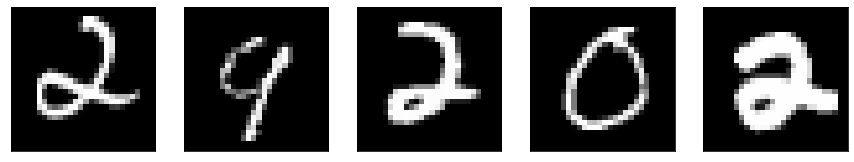

In [3]:
fig, axs = plt.subplots(1, 5, figsize=(15, 10))
idx = np.random.choice(val_data.shape[0], 5)
for i, ax in zip(idx, axs):
    ax.imshow(val_data[i], cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

## PCA and T-SNE on the raw images 

First, we will see how PCA and T-SNE would do on the raw images. 

To get a quantitative evaluation as well, we will run a K-means clustering on the 2-dim projections and look at the adjusted Rand scores with respect the real labels. The Rand score measures the proportion of pairs that are correctly separated/clustered and the adjustment normalizes this value between -1 and 1 to account for chance. An adjusted Rand score of 0 corresponds to uniform random labels and a perfect clustering gives score 1.

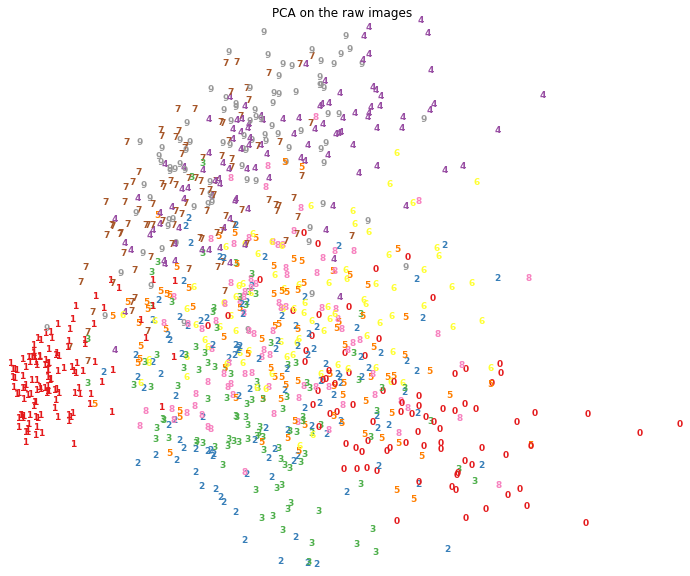

In [4]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca = PCA(n_components=2)
pca_data = pca.fit_transform(val_data.reshape(-1, 28*28))

def plot_clusters(data, labels, title=None, show=False):
    x_min, x_max = np.min(data, 0), np.max(data, 0)
    X = (data - x_min) / (x_max - x_min)
    
    figure = plt.figure(figsize=(12, 10))
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(labels[i]),
                 color=plt.cm.Set1(labels[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    plt.title(title)
    plt.xticks([])
    plt.yticks([])
    sns.despine(top=True, left=True, bottom=True, right=True)
    if show:
        plt.show()
   
    return figure
    
figure = plot_clusters(pca_data, val_labels, title="PCA on the raw images", show=True)

We can evaluate the adjusted Rand index now:

In [5]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

kmeans = KMeans(n_clusters=10)
cluster_labels = kmeans.fit_predict(pca_data)

adjusted_rand_score(cluster_labels, val_labels)

0.25866800587665195

Now, let's try T-SNE:

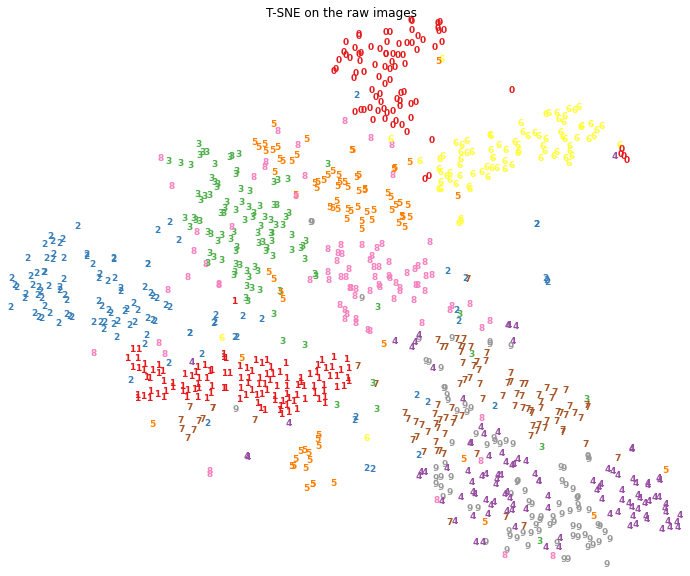

In [6]:
tsne = TSNE(n_components=2)
tsne_data = tsne.fit_transform(val_data.reshape(-1, 28*28))

figure = plot_clusters(tsne_data, val_labels, title="T-SNE on the raw images", show=True)

This looks better which is also reflected in the Rand score:

In [7]:
kmeans = KMeans(n_clusters=10)
cluster_labels = kmeans.fit_predict(tsne_data)

adjusted_rand_score(cluster_labels, val_labels)

0.46338933684264394

T-SNE often does better on lower dimensional data, so we can apply PCA first to reduce the number of dimensions from 784 to say 32 and then proceed with T-SNE to get a 2-dimensional transform.

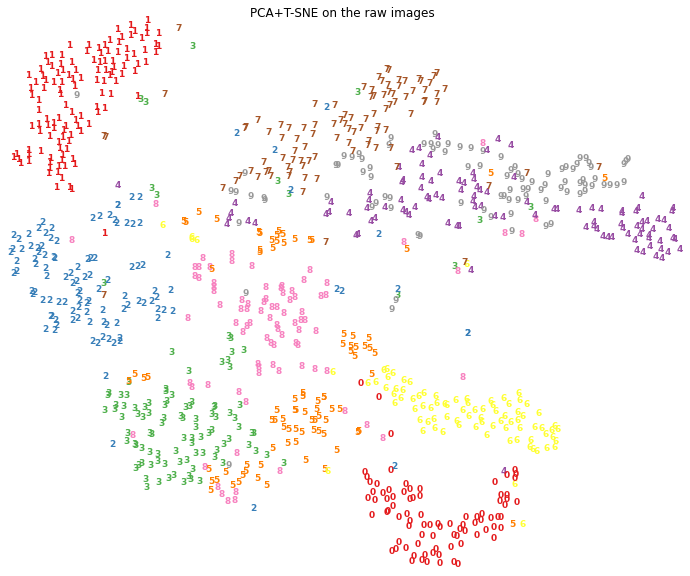

In [8]:
from sklearn.pipeline import Pipeline

model = Pipeline([("pca", PCA(n_components=16)),
                  ("tsne", TSNE(n_components=2))])

projected_data = model.fit_transform(val_data.reshape(-1, 28*28))

figure = plot_clusters(projected_data, val_labels, title="PCA+T-SNE on the raw images", show=True)

In [9]:
kmeans = KMeans(n_clusters=10)
cluster_labels = kmeans.fit_predict(projected_data)

adjusted_rand_score(cluster_labels, val_labels)

0.5618292913992615

I would say this is quite a good result already but T-SNE is pretty sensitive to its training parameters so I bet one can get much better results by some tuning. A super nice comparison of different manifold learning algorithms and 2D MNIST transformations can be found [here at the sklearn docs](https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html#sphx-glr-auto-examples-manifold-plot-lle-digits-py).

## Convolutional variational autoencoder

The VAE model combines the encoder and decoder in with a custom training step. An important step is sampling base on the latent mean/std which is not a differentiable operation so we around this by a simple reparametrization trick: we sample from the standard normal distribution which we translate/scale by our latent mean/std.

In [10]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


class VAE(keras.Model):
    def __init__(self, latent_dim=2, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.latent_dim = latent_dim
        self.encoder = self.get_encoder()
        self.decoder = self.get_decoder()
        
    def get_encoder(self):
        encoder_inputs = keras.Input(shape=(28, 28, 1))
        x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
        x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
        x = layers.Flatten()(x)
        x = layers.Dense(16, activation="relu")(x)

        z_mean = layers.Dense(self.latent_dim, name="z_mean")(x)
        z_log_var = layers.Dense(self.latent_dim, name="z_log_var")(x)

        z = Sampling()([z_mean, z_log_var])

        return keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    
    def get_decoder(self):
        latent_inputs = keras.Input(shape=(self.latent_dim,))

        x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
        x = layers.Reshape((7, 7, 64))(x)
        x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
        x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
        decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)

        return keras.Model(latent_inputs, decoder_outputs, name="decoder")
        
    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
            
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            ) # per-pixel loss
            reconstruction_loss *= 28 * 28
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        
        # calculate gradients     
        grads = tape.gradient(total_loss, self.trainable_weights)
        
        # update the weights
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
          
        return  {
            "loss/total_loss": total_loss,
            "loss/reconstruction_loss": reconstruction_loss,
            "loss/kl_loss": kl_loss,
            "learning_rate": self.optimizer.lr,
        }

## Training 

Some logging utility functions for recording how the latent space and the Rand index is changing:

In [11]:
# logging
logdir = "variational_logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

# image callbacks - source: https://www.tensorflow.org/tensorboard/image_summaries
logdir = "variational_logs/image/" + datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer = tf.summary.create_file_writer(logdir + 'latent/')

def plot_to_image(figure):
    """Converts the matplotlib plot specified by 'figure' to a PNG image and
    returns it. The supplied figure is closed and inaccessible after this call."""
    # Save the plot to a PNG in memory.
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    # Closing the figure prevents it from being displayed directly inside
    # the notebook.
    plt.close(figure)
    buf.seek(0)
    # Convert PNG buffer to TF image
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    # Add the batch dimension
    image = tf.expand_dims(image, 0)
    return image

def log_tsne(epoch, logs):
    tsne = TSNE(n_components=2)
    kmeans = KMeans(n_clusters=10)
    
    z_mean, _, _ = vae.encoder.predict(val_data)
    z_mean_2d = tsne.fit_transform(z_mean)
    cluster_labels = kmeans.fit_predict(z_mean_2d)

    rand_index = adjusted_rand_score(cluster_labels, val_labels)
        
    cluster_figure = plot_clusters(z_mean_2d, val_labels)
    cluster_image = plot_to_image(cluster_figure)
    
    with file_writer.as_default():
        tf.summary.image("Latent clusters", cluster_image, step=epoch)
        tf.summary.scalar("rand_index", rand_index, step=epoch)


# Define the per-epoch callback.
tsne_callback = keras.callbacks.LambdaCallback(on_epoch_end=log_tsne)

In [12]:
vae = VAE(latent_dim=16)
vae.compile(optimizer="adam")

history = vae.fit(train_data, 
                    epochs=15, 
                    batch_size=128, 
                    verbose=1,
                    callbacks=[tensorboard_callback, tsne_callback],
          
)

Epoch 1/15
  1/469 [..............................] - ETA: 0s - loss/total_loss: 545.0065 - loss/reconstruction_loss: 545.0044 - loss/kl_loss: 0.0020 - learning_rate: 0.0010WARNING:tensorflow:From /home/daniel/anaconda3/envs/deeplearning/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
469/469 [==============================] - 158s 336ms/step - loss/total_loss: 207.3911 - loss/reconstruction_loss: 205.7262 - loss/kl_loss: 1.6649 - learning_rate: 0.0010
Epoch 2/15
469/469 [==============================] - 155s 330ms/step - loss/total_loss: 170.3404 - loss/reconstruction_loss: 168.5041 - loss/kl_loss: 1.8363 - learning_rate: 0.0010
Epoch 3/15
469/469 [==============================] - 149s 318ms/step - loss/total_loss: 162.6974 - loss/reconstruction_loss: 160.9073 - loss/kl_loss: 1.7902 - learni

In [29]:
vae.save_weights('models/vae_16d_mnist.ckpt')

In [13]:
%tensorboard --logdir variational_logs/

Reusing TensorBoard on port 6009 (pid 65869), started 19:34:06 ago. (Use '!kill 65869' to kill it.)

## Model evaluation

There seems to be a big variance in Rand index accross the different training runs.

In [16]:
vae = VAE(latent_dim=16)
vae.load_weights('models/vae_16d_mnist.ckpt')

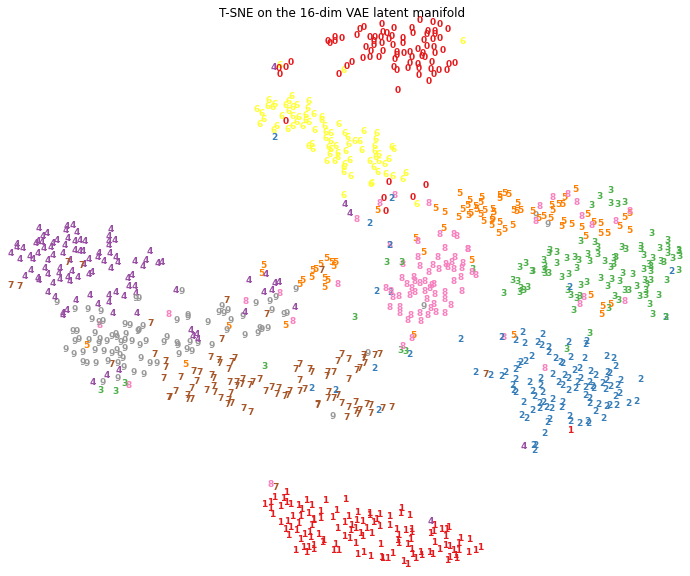

In [17]:
z_mean, _, _ = vae.encoder.predict(val_data)
tsne = TSNE(n_components=2)
z_mean_2d = tsne.fit_transform(z_mean)

figure = plot_clusters(z_mean_2d, val_labels, title="T-SNE on the 16-dim VAE latent manifold", show=True)
figure.savefig("tsne_latent.png")

This looks much better separated compared to our best baseline (PCA+T-SNE) and this is further reflected in the adjusted Rand score.

In [18]:
kmeans = KMeans(n_clusters=10)
cluster_labels = kmeans.fit_predict(z_mean_2d)

adjusted_rand_score(cluster_labels, val_labels)

0.6658474970971847

It would be interesting to see those images which are mixed in with the wrong clusters and also why the 5s were split into two quite distinct cluster.

## Generative plots 

If we fit the VAE with 2D latent embeddings, we have a nice plot for the generated images along the latent 2D manifold.

In [ ]:

def plot_generative(encoder, decoder, show=False):
    # display a n*n 2D manifold of digits
    n = 10
    digit_size = 28
    scale = 2.0
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    fig = plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    if show:
        plt.show()
        
    return fig


In [25]:
vae = VAE(latent_dim=2)
vae.compile(optimizer="adam")

history = vae.fit(train_data, 
                    epochs=15, 
                    batch_size=128, 
                    verbose=1,
                    # callbacks=[tensorboard_callback, latent_plot_callback],
          
)

fig = plot_generative(vae.encoder, vae.decoder, show=True)

ValueError: in user code:

    /home/daniel/anaconda3/envs/deeplearning/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1462 predict_function  *
        return step_function(self, iterator)
    /home/daniel/anaconda3/envs/deeplearning/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1452 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/daniel/anaconda3/envs/deeplearning/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/daniel/anaconda3/envs/deeplearning/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/daniel/anaconda3/envs/deeplearning/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/daniel/anaconda3/envs/deeplearning/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1445 run_step  **
        outputs = model.predict_step(data)
    /home/daniel/anaconda3/envs/deeplearning/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1418 predict_step
        return self(x, training=False)
    /home/daniel/anaconda3/envs/deeplearning/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /home/daniel/anaconda3/envs/deeplearning/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:386 call
        inputs, training=training, mask=mask)
    /home/daniel/anaconda3/envs/deeplearning/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:508 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /home/daniel/anaconda3/envs/deeplearning/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:976 __call__
        self.name)
    /home/daniel/anaconda3/envs/deeplearning/lib/python3.7/site-packages/tensorflow/python/keras/engine/input_spec.py:216 assert_input_compatibility
        ' but received input with shape ' + str(shape))

    ValueError: Input 0 of layer dense_3 is incompatible with the layer: expected axis -1 of input shape to have value 16 but received input with shape [None, 2]
